<a href="https://colab.research.google.com/github/skdarkey/Selorm_Portfolio/blob/main/Food_Images_Classfication_10_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Food Images Classification Project


> Completed By: Selorm Komla Darkey (skdarkey@gmail.com)


A summary of the structure I followed in completing this project:

1. Data download and exploration
2. Preprocessing the data (getting it ready for a model)
3. Creating a first model (which served as baseline for further improvements.)
4. Fit the model
5. Evaluate the model's performance on test data.
6. Adjusting hyperparameters to improve the model and reduce overfitting.
7. Augmenting data for next model
8. Using pretrained models.

**Quick Summary:** I achieved a best result of 41% accuracy from three CNN models I built from scratch, even after augmenting the data. Then I used Transfer learning feature extraction, where I used Resnet50 and EfficientnetB0 architectures to improve the classification to finally realise an accuracy of 91% without overfitting.

Dataset include: 10 classes of food from the Food101 Kaggle dataset, hosted on github.

** Let's Deep Dive**

In [ ]:
# Importing the data.
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip       # data from google storage

# unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-07-30 15:03:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   276MB/s    in 1.8s    

2023-07-30 15:03:10 (276 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Interacting and understanding the data
import os

# Walking through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [ ]:
!ls -la 10_food_classes_all_data/  # checking for default directories

total 16
drwxr-xr-x  4 root root 4096 Jul 30 15:03 .
drwxr-xr-x  1 root root 4096 Jul 30 15:03 ..
drwxr-xr-x 12 root root 4096 Jul 30 15:03 test
drwxr-xr-x 12 root root 4096 Jul 30 15:03 train


In [ ]:
# Seting-up the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Getting the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir) # turning the directory into python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
# visualizing our images
# creating a function to view random images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg   # matplotlib image
import random

def view_random_image(target_dir, target_class):
  """
  Pass in the target directory and the target class. It adds them together to get a random image path in the variable random image
  using the random module. then use matplotlib and matplotlib image to plot the image.
  """
  # Setting-up the target directory.
  target_folder = target_dir + "/" + target_class

  # Getting a random image path
  random_image = random.sample(os.listdir(target_folder), 1)  # randomly samples an item in the target folder and returns the list

  # Reading in the image and plotting it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0]) #
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (384, 512, 3)


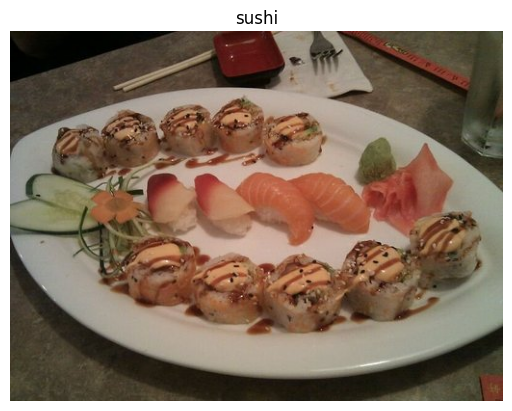

In [ ]:
# Visualizing a random image with its label
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Preprocessing the data to prepare it for the model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale images
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Loading the data in from directories and turning them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224, 224),
                                               class_mode="categorical",
                                               batch_size=32)
# for test data
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                             target_size= (224, 224),
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Creating a CNN model for the data

In [ ]:
# Importing relevant modules
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential


In [ ]:
# Mimicking the model on CNN explainer website

# step 1: building the architecture
model_1 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu",
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])
# step 2: compiling the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fitting the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(len(test_data))
                        )

Epoch 1/5
235/235 [==============================] - 45s 142ms/step - loss: 2.1159 - accuracy: 0.2333 - val_loss: 2.0184 - val_accuracy: 0.2836
Epoch 2/5
235/235 [==============================] - 28s 119ms/step - loss: 1.9165 - accuracy: 0.3335 - val_loss: 1.8761 - val_accuracy: 0.3476
Epoch 3/5
235/235 [==============================] - 33s 139ms/step - loss: 1.6102 - accuracy: 0.4592 - val_loss: 1.8888 - val_accuracy: 0.3252
Epoch 4/5
235/235 [==============================] - 28s 119ms/step - loss: 1.0311 - accuracy: 0.6684 - val_loss: 2.2302 - val_accuracy: 0.3268
Epoch 5/5
235/235 [==============================] - 28s 119ms/step - loss: 0.4796 - accuracy: 0.8504 - val_loss: 2.9088 - val_accuracy: 0.3148


In [ ]:
# Checking summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Evaluating the model

In [ ]:
# Evaluating test data
model_1.evaluate(test_data)

79/79 [==============================] - 7s 92ms/step - loss: 2.9088 - accuracy: 0.3148


[2.908808469772339, 0.3147999942302704]

In [ ]:
# check the loss curves

# Building a function to plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training and validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel('epochs')
  plt.legend()

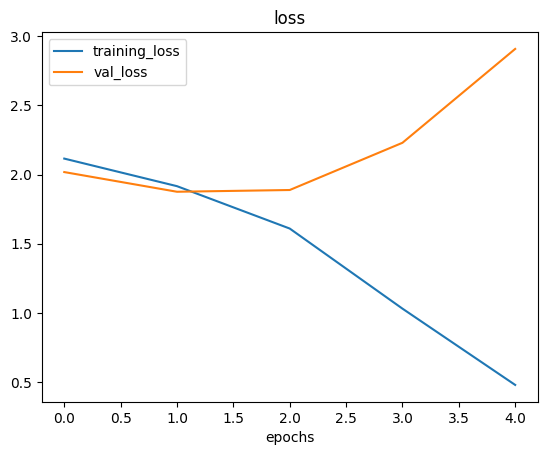

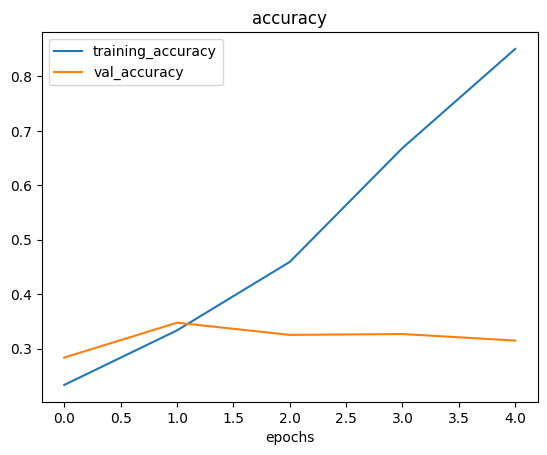

In [ ]:
# Plotting the loss curves
plot_loss_curves(history_1)

*It seems the model is overfitting the training data quite badly.  Its getting great result on the training data but doing badly on new unseen data.*






## Adjusting hyperparameters to improve initial performance

Due to its performance on training data, it seems the model is learning something but, the result is still not good for unseen data.





### Simplifying the model
By removing some layers

In [ ]:
# Building a simplier model ( 2 Conv2D layers removed)
# step 1: Build
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])
# step 2: compile:
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# step 3: Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 28s 115ms/step - loss: 2.1281 - accuracy: 0.2237 - val_loss: 2.0674 - val_accuracy: 0.2648
Epoch 2/5
235/235 [==============================] - 27s 115ms/step - loss: 1.8273 - accuracy: 0.3733 - val_loss: 2.0254 - val_accuracy: 0.3164
Epoch 3/5
235/235 [==============================] - 31s 134ms/step - loss: 1.4359 - accuracy: 0.5227 - val_loss: 2.0520 - val_accuracy: 0.3228
Epoch 4/5
235/235 [==============================] - 30s 129ms/step - loss: 0.9393 - accuracy: 0.7021 - val_loss: 2.4208 - val_accuracy: 0.2684
Epoch 5/5
235/235 [==============================] - 26s 112ms/step - loss: 0.4929 - accuracy: 0.8572 - val_loss: 2.9687 - val_accuracy: 0.2808


In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

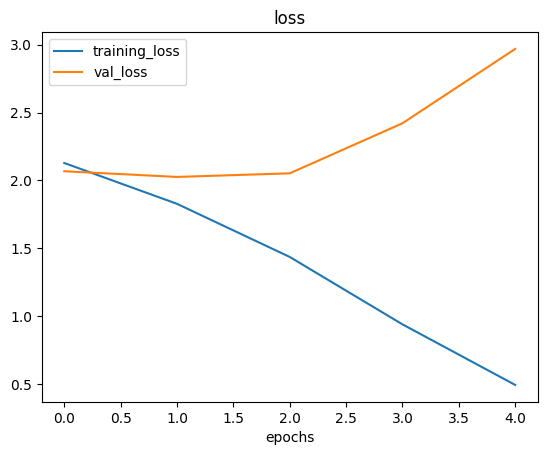

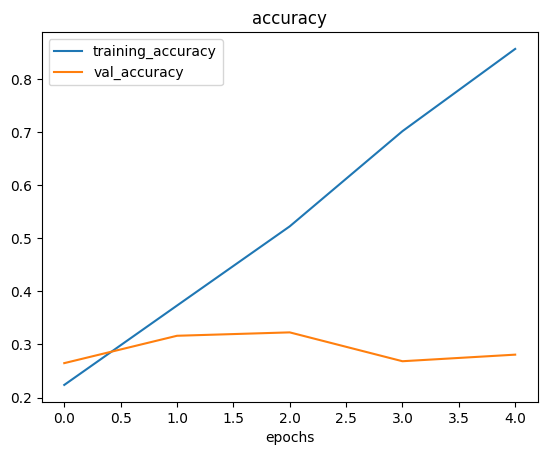

In [ ]:
# plot curves
plot_loss_curves(history_2)

*Just not good yet. The validation accuracy of 28% at this point is not good. Let me try to augment the data and see.*

## Data Augmentation
Ideally, I want to reduce overfitting, get the loss curves and accuracy curves closer and improved on the validation data


In [ ]:
# Creating image data generator instance with augmentation
train_datagen_augmented = ImageDataGenerator(rescale=(1/255.),
                                             rotation_range= 0.2,
                                             zoom_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             horizontal_flip = True)


In [ ]:
# Importing the data and augmenting it from the training directory
print("Augmented Training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224, 224),
                                                                   batch_size=32,
                                                                   class_mode = "categorical")


Augmented Training data:
Found 7500 images belonging to 10 classes.


## New model (cloned my mode 1) and fitting on augmented data

In [ ]:
# cloning the architecture of the model_1 and fiting on augmented training data

# step 1: build
model_3 = tf.keras.models.clone_model(model_1)

# step 2: compiling the cloned model
model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"]
                )
# step 3: Fitting the model
history_3 = model_3.fit(train_data_augmented,
            epochs=5,
            steps_per_epoch=len(train_data_augmented),
            validation_data = test_data,
            validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 103s 432ms/step - loss: 2.2027 - accuracy: 0.1815 - val_loss: 2.0179 - val_accuracy: 0.2612
Epoch 2/5
235/235 [==============================] - 102s 433ms/step - loss: 2.0702 - accuracy: 0.2639 - val_loss: 1.9483 - val_accuracy: 0.3120
Epoch 3/5
235/235 [==============================] - 114s 485ms/step - loss: 1.9963 - accuracy: 0.3039 - val_loss: 1.9089 - val_accuracy: 0.3292
Epoch 4/5
235/235 [==============================] - 109s 463ms/step - loss: 1.9201 - accuracy: 0.3401 - val_loss: 1.8033 - val_accuracy: 0.3708
Epoch 5/5
235/235 [==============================] - 108s 461ms/step - loss: 1.8797 - accuracy: 0.3509 - val_loss: 1.6950 - val_accuracy: 0.4328


*From training result on augmented data, It looks like the training accuracy, although not as high as before is matching the validation accuracy. The model's accuracy on validation data also improved to nearly 43% from the previous 31%.
Let me check now the loss curves.*

In [ ]:
# evaluating model 3 on augmented data
model_3.evaluate(test_data)

79/79 [==============================] - 7s 94ms/step - loss: 1.6950 - accuracy: 0.4328


[1.6949787139892578, 0.4327999949455261]

In [ ]:
# compare with model_1 (which was cloned)
model_1.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 2.9088 - accuracy: 0.3148


[2.908808946609497, 0.3147999942302704]

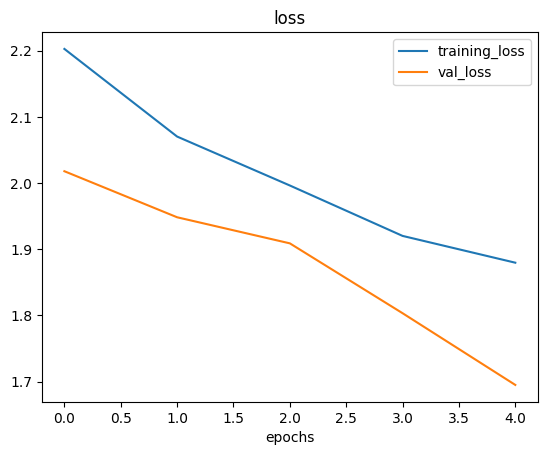

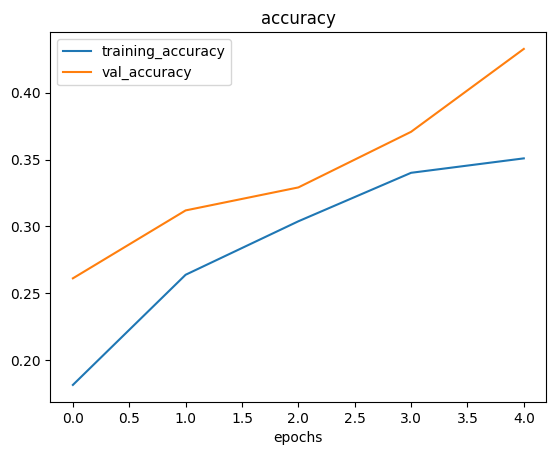

In [ ]:
# plotting the loss curves
plot_loss_curves(history_3)

*Ok, so at least now the loss and accuracy curves are moving together in the right direction. The model is not more overfitting the training data. It seems now that when trained for longer accuracies on both training and accuracies can improve.*

### Repeating the training.



In [ ]:
# let me train model 3 again for longer and see if it does improve
# Training same model again for longer

# step 1: Build
model_4 = tf.keras.models.clone_model(model_1)

# step 2: compiling model
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"]
                )
# step 3: fitting the model
history_4 = model_4.fit(train_data_augmented,
            epochs=10,
            steps_per_epoch=len(train_data_augmented),
            validation_data = test_data,
            validation_steps=len(test_data))

Epoch 1/10
235/235 [==============================] - 112s 461ms/step - loss: 2.1727 - accuracy: 0.2012 - val_loss: 2.0620 - val_accuracy: 0.2740
Epoch 2/10
235/235 [==============================] - 110s 467ms/step - loss: 2.0904 - accuracy: 0.2420 - val_loss: 1.9695 - val_accuracy: 0.3064
Epoch 3/10
235/235 [==============================] - 109s 461ms/step - loss: 2.0343 - accuracy: 0.2772 - val_loss: 1.8826 - val_accuracy: 0.3356
Epoch 4/10
235/235 [==============================] - 106s 452ms/step - loss: 1.9735 - accuracy: 0.3143 - val_loss: 1.8123 - val_accuracy: 0.3752
Epoch 5/10
235/235 [==============================] - 102s 435ms/step - loss: 1.9366 - accuracy: 0.3240 - val_loss: 1.8022 - val_accuracy: 0.3940
Epoch 6/10
235/235 [==============================] - 102s 432ms/step - loss: 1.9009 - accuracy: 0.3444 - val_loss: 1.7821 - val_accuracy: 0.3804
Epoch 7/10
235/235 [==============================] - 100s 428ms/step - loss: 1.8740 - accuracy: 0.3511 - val_loss: 1.8485 -

*No real improvement was achieved.*

### Making prediction with the model on own custom images.

In [ ]:
# let me see all the class names again
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Downloading some custom data from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg

--2023-07-30 15:41:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2023-07-30 15:41:28 (42.8 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]

--2023-07-30 15:41:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
# Creating a function to import an image and resize it to be fit for the model

def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
  """
  # Reading in the file using the io module
  img = tf.io.read_file(filename)
  # Decoding the read file into a tensor
  img = tf.image.decode_image(img)
  # Resizing the image
  img = tf.image.resize(img, size=[img_shape, img_shape])     # gets it to 224, 224
  # Re-scaling the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Creating a function to predict and plot custom images using the model
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with the model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Addingt logic for multi-class & getting pred_class names
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names(int(tf.round(pred[0])))

  # Plotting the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 295ms/step


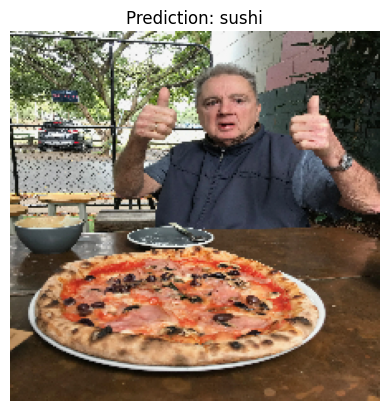

In [ ]:
# Making the prediction and ploting
pred_and_plot(model=model_4,
              filename="03-pizza-dad.jpeg",     # name of the file downloaded
              class_names=class_names)

1/1 [==============================] - 0s 27ms/step


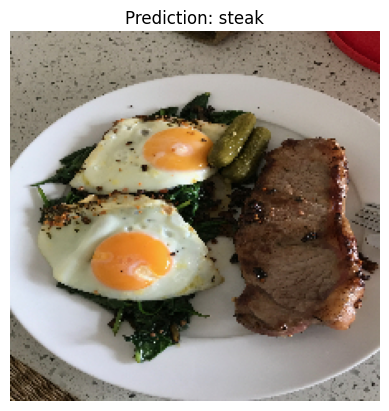

In [ ]:
# Making the prediction and ploting for another image
pred_and_plot(model=model_4,
              filename="03-steak.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 29ms/step


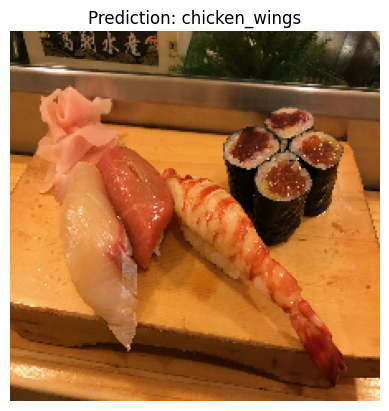

In [ ]:
# Making the prediction and ploting for another image
pred_and_plot(model=model_4,
              filename="03-sushi.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 24ms/step


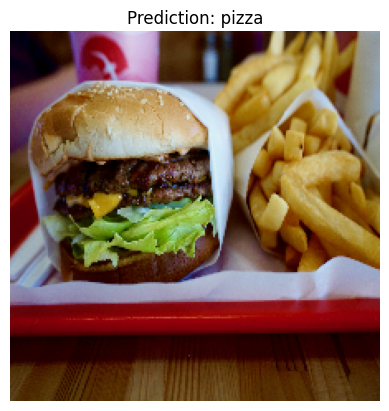

In [ ]:
# Making the prediction and ploting for another image
pred_and_plot(model=model_4,
              filename="03-hamburger.jpeg",
              class_names=class_names)

*It looks like the model is performing poorly. Getting only 1 out of 4 correct of our custom images. This is because it achieves just about 40 accuracy on the test data.*

In [ ]:
# Save model
model_4.save("saved_trained_model_4")

In [ ]:
# Loading a model in
loaded_model_4 = tf.keras.models.load_model("saved_trained_model_4")
# evaluate the loaded model again on test data
loaded_model_4.evaluate(test_data)

79/79 [==============================] - 6s 78ms/step - loss: 1.7434 - accuracy: 0.4132


[1.7434402704238892, 0.4131999909877777]

In [ ]:
# Compare the loaded model to the existing model
model_4.evaluate(test_data)

79/79 [==============================] - 6s 79ms/step - loss: 1.7434 - accuracy: 0.4132


[1.7434406280517578, 0.4131999909877777]

**Summary of Section 1:**
* In this section I build Convolutional Neural Networks models for multiclass food image classification. I use the CNN Explainer website and modeled my first CNN model after it.
* The first model didn't do well. So I tried and improved its performance using data agumentation.
* The next models performed a little better but still not satisfied enough with the result.
* I used new custom images from github to evaluate the model's prediction, it only got 1 out of 4 correct.
* In the next section, I explored using pre-trained models to see if the model improves.

# Section 2: Transfer Learning for improvement

In [ ]:
# Getting the data (just 10% of the food classes data)
import zipfile

# Downloading smaller dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-30 15:43:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   169MB/s    in 1.0s    

2023-07-30 15:43:46 (169 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# walk through the directories
import os

# walk through the directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Creating Data loaders again (preparing the data)

In [ ]:
# Seting up the inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir_10 = "10_food_classes_10_percent/train"
test_dir_10 = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir_10,               # now 10 percent of the previous training data
                                                       target_size = IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode = "categorical")
print("Training images")
test_data_10 = test_datagen.flow_from_directory(test_dir_10,
                                             target_size = IMAGE_SHAPE,
                                             class_mode = "categorical")

Found 750 images belonging to 10 classes.
Training images
Found 2500 images belonging to 10 classes.


## Setting up a TensorBoard callback to track model

In [ ]:
# Creating TensorBoard callback by functionizing it be able to use later
import tensorflow as tf
import datetime   #  to track the dates the models were trained

def create_tensorboard_callback(dir_name, expirement_name):
  """ It takes a directory name, where to store the callbacks and the name of the specific model.
  """
  log_dir = dir_name + "/" + expirement_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # creates a directory with current time
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

## Creating a Model using Tensorflow Hub:
Tensorflow Hub is a repository of trained machine learning models that can be adapted for specific use cases.

I attempt to use 2 pretrained CNN models from tensorflow Hub to improve my image classification result.


Browsing through the Tensorflow Hub page and sorting through Image Classification models, I choosed 2 well performing models. 1 resnet architecture model and 1 efficientnet model.
> * resnet mode --> "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
* Efficient Net model --> "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# I will be adapting and comparing the following two models on my classification task.
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import some relevant dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# defining a function to create a model from tfhub URL
def create_model(model_url, num_classes = 10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pre-train model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,   # freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))

  # Create a new model out of downloaded architecture and add my output Dense layer
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")  # my desired output layer on top
  ])
  return model

### Creating ResNet Tensorflow Hub feature extraction model

In [ ]:
# Creating ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# getting the summary of the model
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compiling the resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
# Fitting the resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data = test_data_10,
                 validation_steps=len(test_data_10),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        expirement_name="resnet50_v2")])

saving TensorBoard log files to tensorflow_hub/resnet50_v2/20230730-160431
Epoch 1/5
24/24 [==============================] - 20s 626ms/step - loss: 1.9245 - accuracy: 0.3453 - val_loss: 1.2017 - val_accuracy: 0.6272
Epoch 2/5
24/24 [==============================] - 13s 547ms/step - loss: 0.8880 - accuracy: 0.7307 - val_loss: 0.8477 - val_accuracy: 0.7348
Epoch 3/5
24/24 [==============================] - 11s 480ms/step - loss: 0.6013 - accuracy: 0.8413 - val_loss: 0.7459 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 12s 503ms/step - loss: 0.4737 - accuracy: 0.8853 - val_loss: 0.7078 - val_accuracy: 0.7772
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 0.3743 - accuracy: 0.9160 - val_loss: 0.6811 - val_accuracy: 0.7828


**Observation** Great result. The adapted ResNet model out performed all the multiclass food classification models I built manually early on substantially........and in quicker training time as well.
* This was achieved while using only 10 percent of the initial training data this time round.

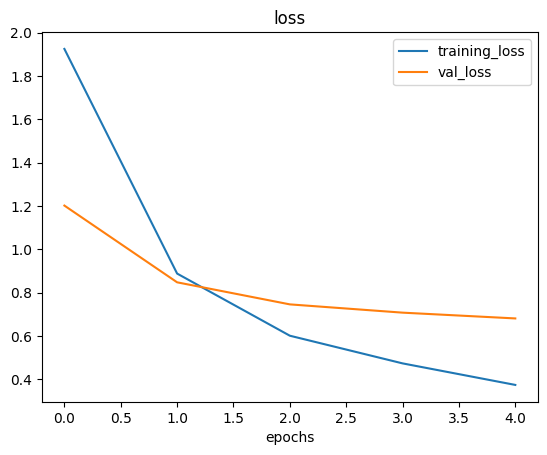

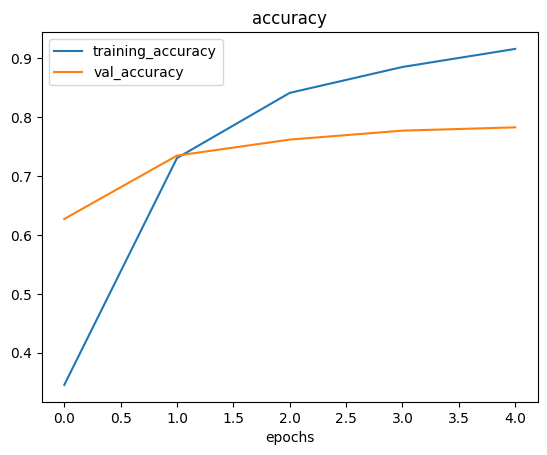

In [ ]:
# plot loss curves

plot_loss_curves(resnet_history)

**Observation** The loss curves looks way better than those of the previous manually created models. The model is not overfitting and the training and validation loss and accuracies are reducing together and increasing together respectively.

### Creating and testing EfficientNet Tensorflow Hub Feature Extraction model

In [ ]:
# Creating Efficientnet model
efficientnet_model = create_model(model_url= efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compiling the efficient net model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [ ]:
# Fitting the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10,
                                              validation_steps=len(test_data_10),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    expirement_name="efficientnetb0")])

saving TensorBoard log files to tensorflow_hub/efficientnetb0/20230730-161840
Epoch 1/5
24/24 [==============================] - 23s 514ms/step - loss: 1.8408 - accuracy: 0.4187 - val_loss: 1.3121 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 10s 429ms/step - loss: 1.0505 - accuracy: 0.7787 - val_loss: 0.8722 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 12s 535ms/step - loss: 0.7424 - accuracy: 0.8347 - val_loss: 0.7038 - val_accuracy: 0.8332
Epoch 4/5
24/24 [==============================] - 9s 405ms/step - loss: 0.5977 - accuracy: 0.8667 - val_loss: 0.6184 - val_accuracy: 0.8472
Epoch 5/5
24/24 [==============================] - 9s 393ms/step - loss: 0.5061 - accuracy: 0.8907 - val_loss: 0.5634 - val_accuracy: 0.8552


**Observation:** The efficientnet model's performance is super. achieves 85% validation accuracy. It was very fast and doesn't seem to be overfitting. Let me check out the loss curves

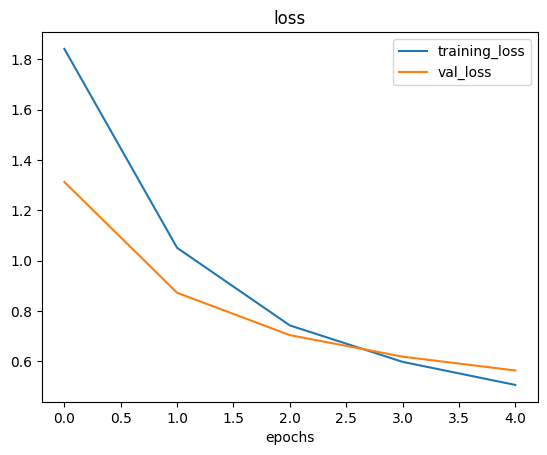

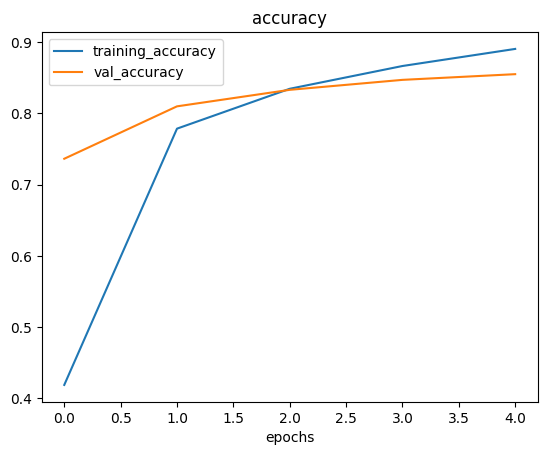

In [ ]:
# plot loss curves
plot_loss_curves(efficientnet_history)

Great results.

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Investigating the Efficientnet model. How many layers does the efficientnet feature extractor have?
# efficientnet_model.layers[0].weights
len(efficientnet_model.layers[0].weights)

309

### Fitting the best performning model pre-trained model on all the data

In [ ]:
# Fitting the best model yet on all the data (7500 images)
efficientnet2_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    expirement_name="efficientnetb0_All_data")])

saving TensorBoard log files to tensorflow_hub/efficientnetb0_All_data/20230730-164256
Epoch 1/5
235/235 [==============================] - 31s 129ms/step - loss: 0.2602 - accuracy: 0.9231 - val_loss: 0.2657 - val_accuracy: 0.9152
Epoch 2/5
235/235 [==============================] - 30s 127ms/step - loss: 0.2409 - accuracy: 0.9289 - val_loss: 0.2672 - val_accuracy: 0.9156
Epoch 3/5
235/235 [==============================] - 30s 128ms/step - loss: 0.2224 - accuracy: 0.9367 - val_loss: 0.2630 - val_accuracy: 0.9156
Epoch 4/5
235/235 [==============================] - 30s 129ms/step - loss: 0.2074 - accuracy: 0.9415 - val_loss: 0.2598 - val_accuracy: 0.9164
Epoch 5/5
235/235 [==============================] - 30s 126ms/step - loss: 0.1941 - accuracy: 0.9457 - val_loss: 0.2613 - val_accuracy: 0.9184


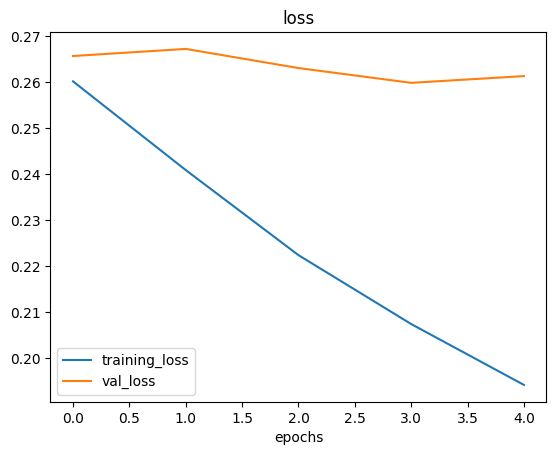

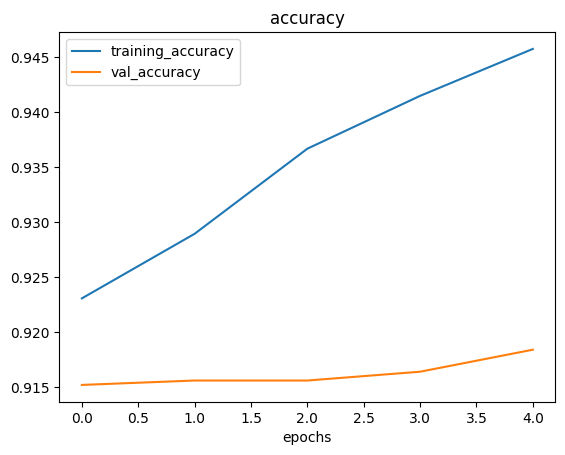

In [ ]:
# plot loss curves
plot_loss_curves(efficientnet2_history)

**Observation:** The efficientnet model produced overall best result. Even while trained on only 10 percent of the data, it's performance beats all my manually built models.
* When trained on larger data, its performance just improved further reaching an accuracy of 92% on validation data. That is Super.

### Making prediction with the improved model

1/1 [==============================] - 1s 1s/step


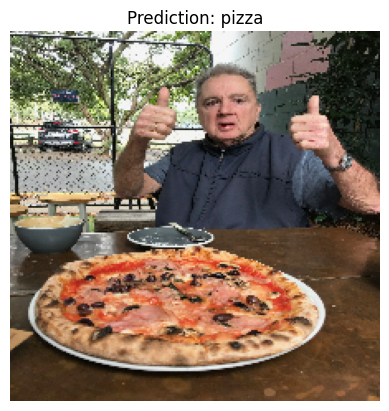

In [ ]:
# Making the prediction for pizza
pred_and_plot(model=efficientnet_model,
              filename="03-pizza-dad.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 26ms/step


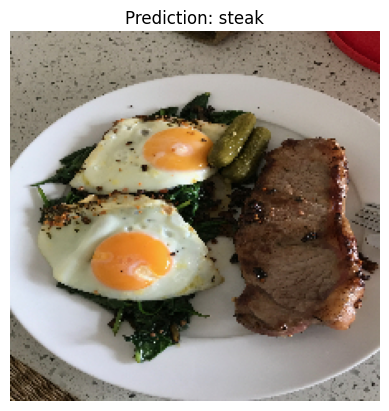

In [ ]:
# Making the prediction for steak
pred_and_plot(model=efficientnet_model,
              filename="03-steak.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 25ms/step


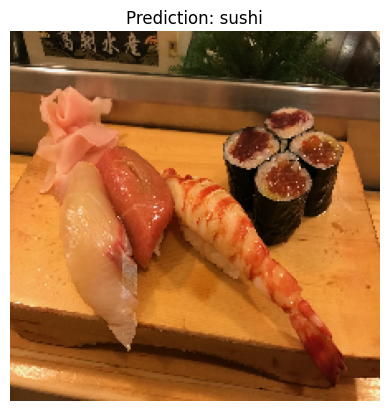

In [ ]:
# Making the prediction for sushi
pred_and_plot(model=efficientnet_model,
              filename="03-sushi.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 25ms/step


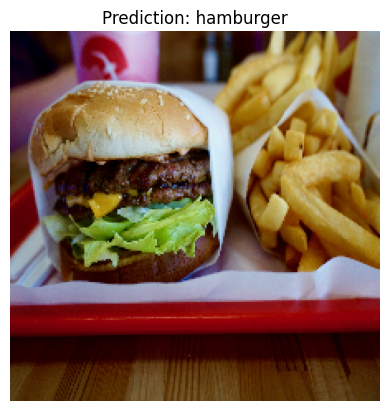

In [ ]:
# Making the prediction for hamburger
pred_and_plot(model=efficientnet_model,
              filename="03-hamburger.jpeg",
              class_names=class_names)

In [ ]:
# Saving the best model yet
efficientnet_model.save("Best_Food_Classfication_model_EffNet")

In [ ]:
# Upload TensorBoard dev records ( From the records saved from the callback function into the log_directory)
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10 percent of initial training data" \
  --one_shot # the one_shot ends the uploader

The model tracking records have been uploaded to tensorboard and can be found here: https://tensorboard.dev/experiment/30839Ov7Q9aJkjfkDK8SrA/

In [ ]:
# Checking out what TensorBoard expirements I have ?
!tensorboard dev list

2023-07-30 17:04:27.531408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/30839Ov7Q9aJkjfkDK8SrA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10 percent of initial training data
	Id                   30839Ov7Q9aJkjfkDK8SrA
	Created              2023-07-30 16:57:41 (6 minutes ago)
	Updated              2023-07-30 16:57:45 (6 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  14115049
Total: 1 experiment(s)


### Final toughts:
* It was a great learning for me to have completed this project.
* Summary of key things I did in this project:
> * I started of with the challenge to build Convolutional Neural Network to classify 10 different classes of food images.
> * I downloaded and pre-processed the data. At this stage, I created an Image Data generator instance to rescale and reshape the images from different shapes to one standard shape.
> * I built and trained 2 Convolutional Neural Network models, which were inspired by the CNN Explainer website Tiny VGG CNN architecture. Unfortunately, the evaluation results were poor. Reaching aroun 30% accuracy level.
> * Then I augmented the training data, and built 2 more CNN models to train on the augmented data. The results slightly improved reaching 40%, yet not satisfying.
> * Next, I explored 2 pre-trained models from Tensorflow hub, and adapted them to my use case. And I reduced the training data from 7500, to 750.
> * The ResNet pre-trained model achieved better validation accuracy with the testing data, reaching 78% accuracy level, although trained on just 10% of the initial data.
> * The Efficientnet pre-trained model even further increased performance, achieving 85% accuracy when trained on 10% of initial data, then 92% when trained of the full training dataset.
> * The model's prediction on all custom new food images introduced to it were correct.
> * I saved the best performing model.
> * I published the performances records of the best performing models to TensorBoard which can be seen publicly [here](https://tensorboard.dev/experiment/30839Ov7Q9aJkjfkDK8SrA/)
